## Vector Autoregression (VAR)

In [25]:
# Import all required libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [26]:
# Import feature and target columns
df = pickle.load(open("../common/df.p", "rb"))
split_loc = pickle.load(open("../common/n_obs.p", "rb"))
n_splits = pickle.load(open("../common/n_splits.p", "rb"))

### Check for Stationarity 

In [27]:
def check_stationarity(data):
    result = adfuller(data)
    if result[1] < 0.05:
        print("Stationary")
    else:
        print("Non-Stationary")

# Apply this function to each column of your DataFrame
df.apply(check_stationarity)

Stationary
Stationary
Stationary
Stationary
Stationary
Stationary
Stationary


cpu_usage             None
memory_usage          None
bandwidth_inbound     None
bandwidth_outbound    None
tps                   None
tps_error             None
response_time         None
dtype: object

### Perform Cross Validation

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return np.mean(2.0 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

In [29]:
window_size = len(df) // n_splits

# Initialize a dictionary to store the MSEs, MAPEs, SMAPEs for each variable
mse_dict = {var: [] for var in df.columns}
mape_dict = {var: [] for var in df.columns}
smape_dict = {var: [] for var in df.columns}

for i in range(n_splits):
    if i < n_splits - 1:
        train, test = df[i*window_size:(i+1)*window_size], df[(i+1)*window_size:(i+2)*window_size]
    else:  # If it's the last split, use the rest of the data for the test set
        train, test = df[i*window_size:(i+1)*window_size], df[(i+1)*window_size:]
    
    # Fit the VAR model
    model = VAR(train)
    model_fit = model.fit(maxlags=5, ic='aic')  # Choose order of VAR with Akaike's Information Criterion
    
    # Make predictions on the test set
    n_obs = len(test)  # Dynamically adjust the number of observations to forecast
    predictions = model_fit.forecast(model_fit.model.endog, steps=n_obs)
    
    # Calculate mean squared error for each variable and store it in the dictionary
    for j, var in enumerate(train.columns):
        mse = mean_squared_error(test.iloc[:, j], predictions[:, j])
        mape = mean_absolute_percentage_error(test.iloc[:, j].values, predictions[:, j])
        smape_value = smape(test.iloc[:, j].values, predictions[:, j])
        mse_dict[var].append(mse)
        mape_dict[var].append(mape)
        smape_dict[var].append(smape_value)

# Compute and print the average MSE for each variable
for var in mse_dict:
    avg_mse = sum(mse_dict[var]) / len(mse_dict[var])
    print(f'Average MSE for {var}: {avg_mse}')

print("-----------------------------------------")

# Compute and print the average MAPE for each variable
for var in mape_dict:
    avg_mape = sum(mape_dict[var]) / len(mape_dict[var])
    print(f'Average MAPE for {var}: {avg_mape}')

print("-----------------------------------------")

# Compute and print the average SMAPE for each variable
for var in smape_dict:
    avg_smape = sum(smape_dict[var]) / len(smape_dict[var])
    print(f'Average SMAPE for {var}: {avg_smape}')

Average MSE for cpu_usage: 0.011390920257782638
Average MSE for memory_usage: 1.44648013910263e-05
Average MSE for bandwidth_inbound: 39795744.40062205
Average MSE for bandwidth_outbound: 25708117.381725766
Average MSE for tps: 0.6792662484422436
Average MSE for tps_error: 0.18945668547028954
Average MSE for response_time: 514198.4374786808
-----------------------------------------
Average MAPE for cpu_usage: 126.821342258525
Average MAPE for memory_usage: 0.6659487996310652
Average MAPE for bandwidth_inbound: 1076.484432610586
Average MAPE for bandwidth_outbound: 1032.9534354092707
Average MAPE for tps: 55.348696479226135
Average MAPE for tps_error: inf
Average MAPE for response_time: 49.42706820523503
-----------------------------------------
Average SMAPE for cpu_usage: 49.324512652706325
Average SMAPE for memory_usage: 0.6671295296187708
Average SMAPE for bandwidth_inbound: 79.81226331477602
Average SMAPE for bandwidth_outbound: 73.20974637631039
Average SMAPE for tps: 38.336445235

C:\Users\dell\AppData\Local\Temp\ipykernel_12836\526402965.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\dell\AppData\Local\Temp\ipykernel_12836\526402965.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\dell\AppData\Local\Temp\ipykernel_12836\526402965.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\dell\AppData\Local\Temp\ipykernel_12836\526402965.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


### Train the model

In [30]:
# Split your data
train_df, test_df = df[:split_loc], df[split_loc:]

In [31]:
# Now fit a VAR model on the training dataset
model = VAR(train_df)
model_fit = model.fit(maxlags=15, ic='aic')

In [32]:
# Make predictions. The forecast method requires the number of steps to forecast and the data used for forecasting.
lag_order = model_fit.k_ar
predictions = model_fit.forecast(train_df.values[-lag_order:], len(test_df))

In [33]:
# Since the forecast returns an array, we can turn it back into a DataFrame to make it easier to work with.
pred_df = pd.DataFrame(predictions, index=test_df.index, columns=test_df.columns)

In [34]:
smape_values = {}

for col in df.columns:
    smape_values[col] = smape(test_df[col], pred_df[col])
    print(f'SMAPE for {col}: {smape_values[col]}')

SMAPE for cpu_usage: 50.14761760546931
SMAPE for memory_usage: 0.5038814038188058
SMAPE for bandwidth_inbound: 66.91174009146079
SMAPE for bandwidth_outbound: 64.8449418735249
SMAPE for tps: 42.76800022604646
SMAPE for tps_error: 192.2790827548802
SMAPE for response_time: 49.786979884606474


### Visualize the model

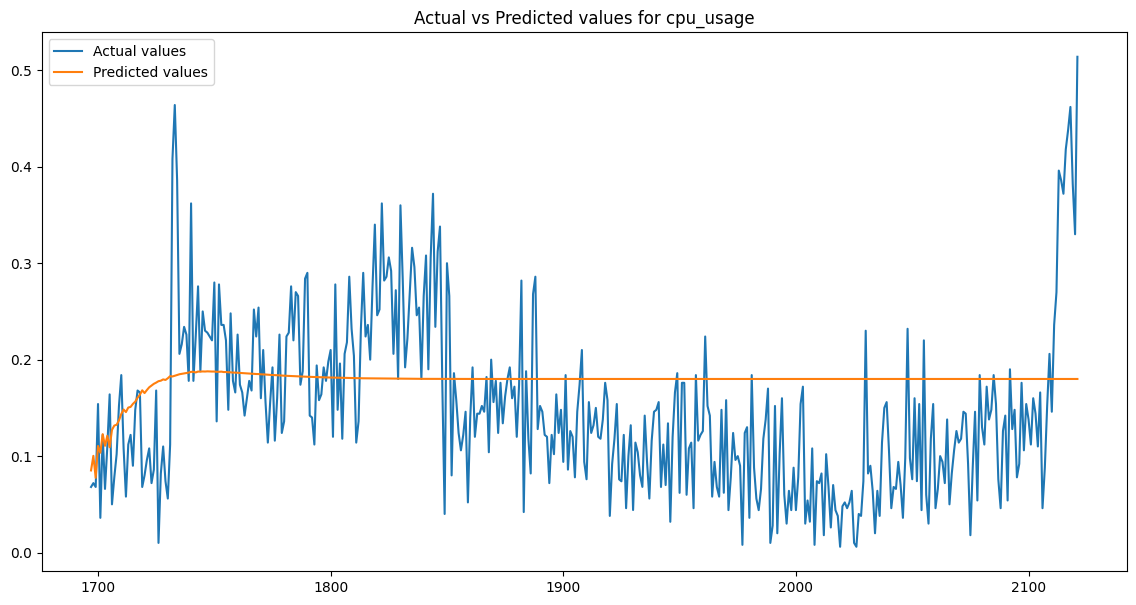

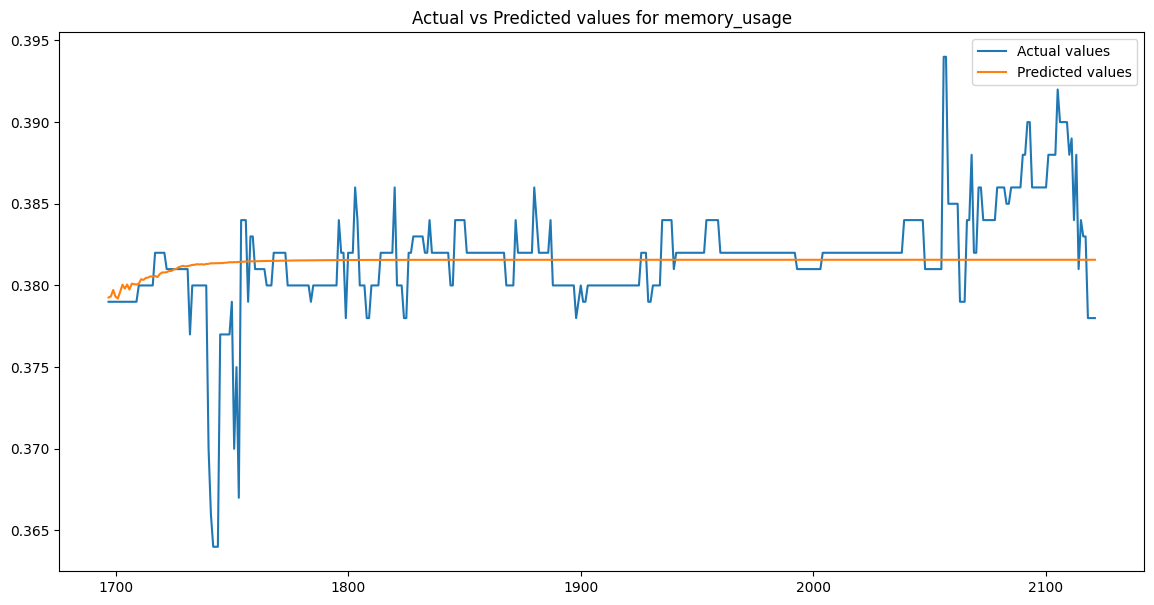

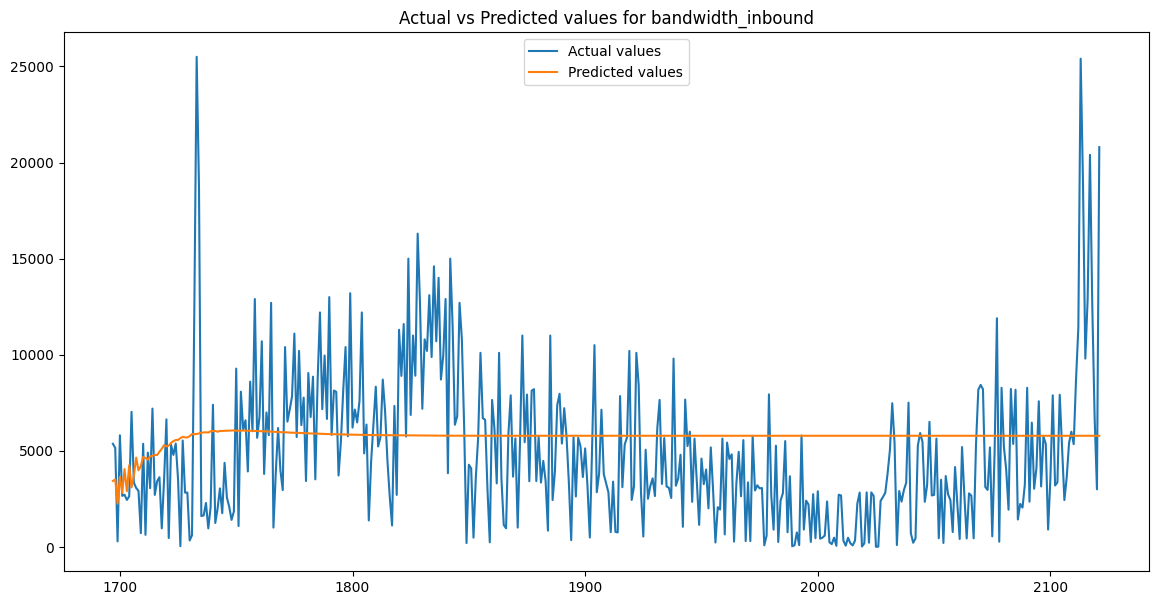

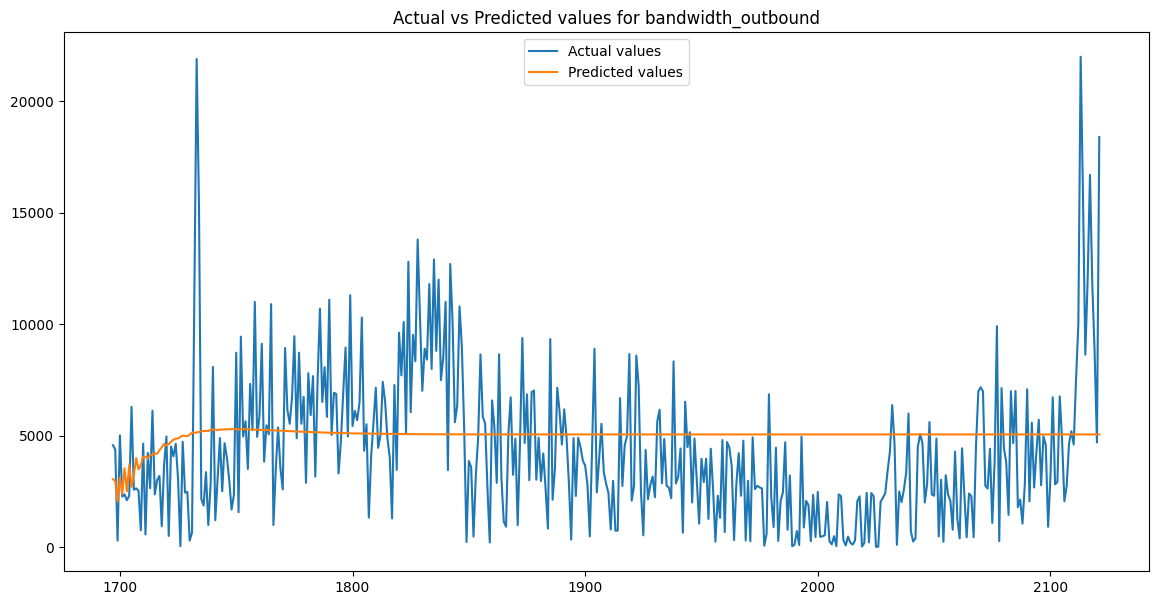

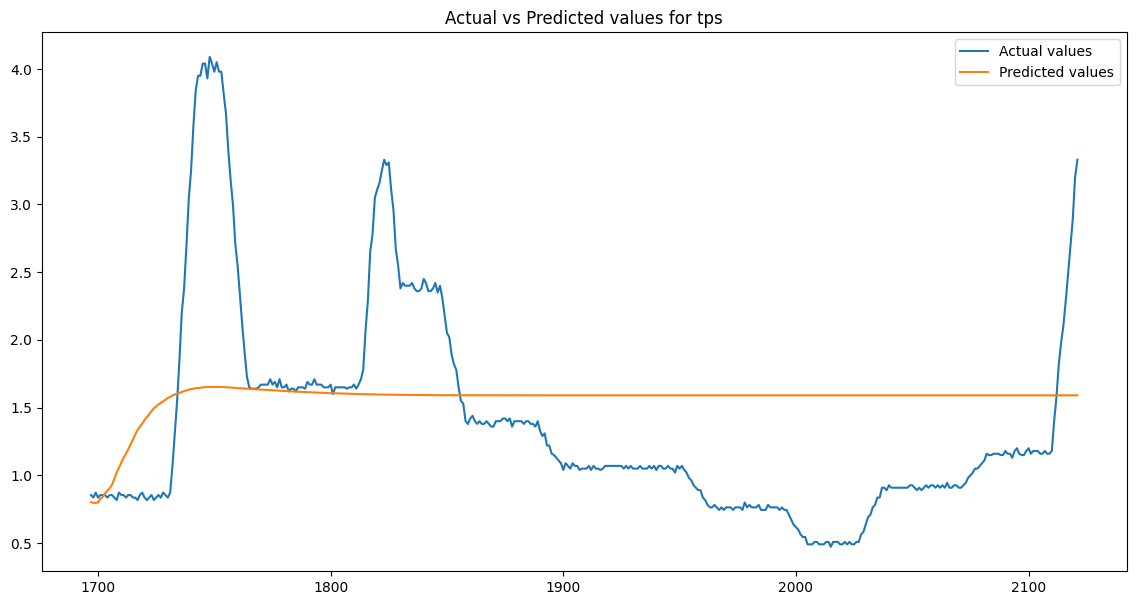

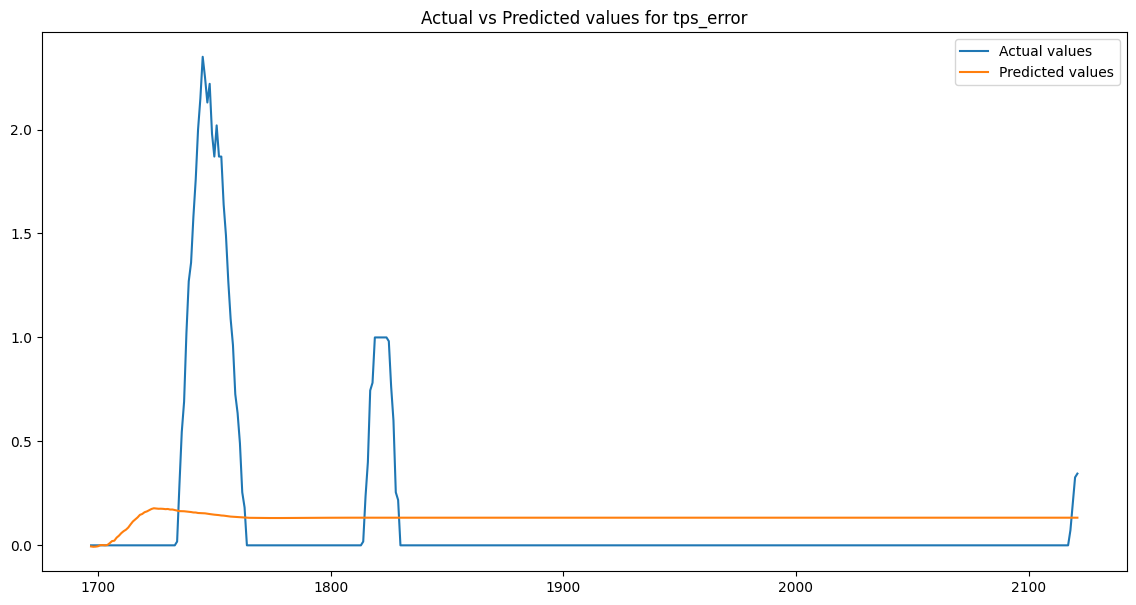

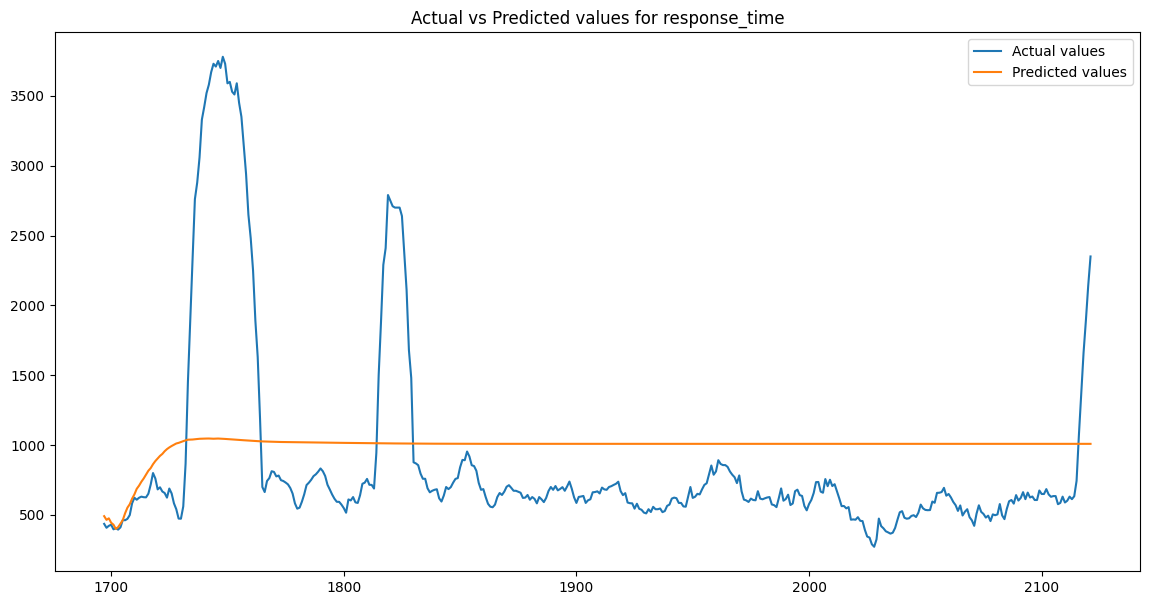

In [35]:
for col in df.columns:
    plt.figure(figsize=(14,7))
    plt.plot(test_df[col], label='Actual values')
    plt.plot(pred_df[col], label='Predicted values')
    plt.legend(loc='best')
    plt.title(f'Actual vs Predicted values for {col}')
    plt.show()

### Export the model

In [36]:
pickle.dump(model_fit, open("../models/multi-step-multivariate/var.p", "wb"))